# Diffusion map

## import needed packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import warnings
from math import*
import copy

from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import normalize
import scipy.sparse.linalg as spsl
from scipy import sparse

from diffusion_map import*

## set parameters

In [2]:
test_data = "swiss_roll" #set the type of the test_data; "swiss_roll", "VDem" and "helix" are possible
epsilon = 0.1
take_guess_epsilon = False #take the epsilon which is guessed by a algorithm from Maria Cameron
take_nearest_neighbours = "all" #take x nearest neighbours to calculate the diffusion map; if set to "all" all entries are taken into account
t = 1 #number of timesteps happens at the diffusion process


## create test data

In [3]:
#save data in X
if test_data == "swiss_roll":
    X, color = make_swiss_roll(n_samples=1000, noise=0.1, hole=True)
elif test_data == "helix":
    X, color = create_helix(1, 1,6, 200)
elif test_data == "blobs":
    X = make_blobs(n_samples=1000, n_features=10,cluster_std=0.2)[0]
    #X =  np.insert(X[0], 2, 0, axis=1)
    color = "Blue" 
elif test_data == "VDem":
    path_VDEM = r'C:\Users\Sönke Beier\Desktop\Uni-Daten\Master\Demokratie_Wiesner_Masterarbeit\V-Dem-CY-FullOthers_csv_v13\MASTER_data_with_principal_components.csv'
    X = pd.read_csv(path_VDEM,low_memory = False)
    X = np.array(X.iloc[:,6:])
    color = "Blue"

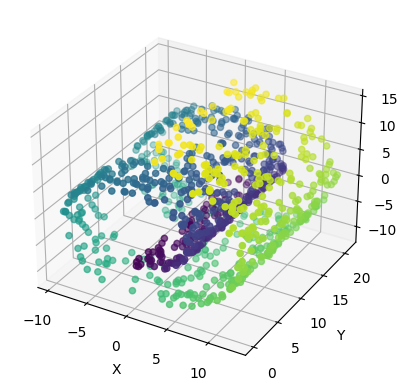

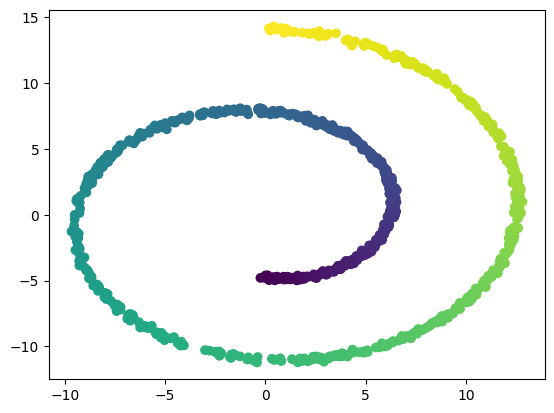

In [4]:
#show created data 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


#show created data 2d
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:, 0], X[:, 2], c=color)

# Show the plot
plt.show()

## Calculate diffusion map

In [5]:
print("loaded " + str(X.shape[0]) + " Output_Areas/countries/rows, " + str(X.shape[1]) + " Variables/indices/columns")

loaded 1000 Output_Areas/countries/rows, 3 Variables/indices/columns


In [6]:
#Standardize X, so that the mean of each column is 0 and the standard deviation is 1 (mean 0, sd 1)
X = standardize_matrix(X)

#save_matrix(X,name = "X_stand", folder_name = "diffusion_map")


Mean and standard deviation before standardizing:
Before standardizing: column: 0, mean = 3.12110924408689, standard deviation = 6.241183312682043
After standardizing: column: 0, mean = 1.2434497875801754e-17, standard deviation = 1.0
Before standardizing: column: 1, mean = 10.392653303251354, standard deviation = 6.4991179598029465
After standardizing: column: 1, mean = 6.572520305780926e-17, standard deviation = 1.0
Before standardizing: column: 2, mean = 0.5810070837320082, standard deviation = 7.011987655703301
After standardizing: column: 2, mean = -5.3290705182007515e-18, standard deviation = 1.0


In [7]:
#Compute Euclidean distances between data points (create Distance Matrix D)
D = calculate_distance_matrix(X, methode = "sklearn")

#save_matrix(D,name = "D", folder_name = "diffusion_map")

calculated distances in  0.012174844741821289  seconds.


In [8]:
#Calculate fitting epsilon (see "Diffusion Map" lecture notes from Maria Cameron)
guess_epsilon = guess_epsilon_Cameron(D)

if take_guess_epsilon:
    epsilon = guess_epsilon 
    
print("initital guess epsilon = ", guess_epsilon)

Compute...: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 21742.96it/s]

initital guess epsilon =  0.026269163798881237


In [9]:
#Calculate kernel matrix K
K = calculate_kernel_matrix(D, epsilon, kernel = "gaussian")
#save_matrix(K,name = "K", folder_name = "diffusion_map")

Compute...: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3430.16it/s]

calculated kernel matrix in  0.2984769344329834  seconds.


In [10]:
#for i in range(K.shape[0]):
#    K[i,i] = 0

In [11]:
#Deleting minor entries of K
if not take_nearest_neighbours == 'all':
    K = only_take_nearest_neighbours(K,number_neighbours = take_nearest_neighbours)
    
    #save_matrix(K,name = "K_tresh", folder_name = "diffusion_map")

In [12]:
# Create transition matrix P by normalizing rows of K
P = normalizing_rows(K)


#TODO: Eigenvalues sind nur lambda^t, eigenvectoren die selben: https://proofwiki.org/wiki/Eigenvalue_of_Matrix_Powers

Compute...: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1024.56it/s]

Sums of first rows after normalization: 
1.0000000000000002,1.0000000000000004,1.0000000000000004,1.0000000000000016,1.0000000000000007,1.0000000000000007,0.9999999999999992,0.9999999999999998,0.9999999999999997,0.9999999999999997,1.0000000000000009,1.0000000000000002,1.0000000000000004,0.9999999999999997,0.9999999999999998,1.0000000000000002,1.0,0.9999999999999994,0.9999999999999996,1.000000000000001,

In [13]:
#for i in range(P.shape[0]):
#    P[i,i] = P[i,i]-1

In [14]:
#Calculate power of the transition matrix; t gives the number of timesteps for the diffusion process
P = np.linalg.matrix_power(P,t)
P = sparse.csr_matrix(P)
save_matrix(P,name = "Pt", folder_name = "diffusion_map")

saved matrix in  0.2679727077484131  seconds.


In [15]:
#Calculate eigenvalues and eigenvectors of P
diffusion_map, sorted_eigenvalues, sorted_eigenvectors = calculate_diffusion_map(P)

save_matrix(diffusion_map,name = "diffusion_map", folder_name = "diffusion_map")
save_matrix(sorted_eigenvectors, name = "sorted_eigenvectors ", folder_name = "diffusion_map")
save_matrix(sorted_eigenvalues, name = "sorted_eigenvalues", folder_name = "diffusion_map")

calculated eigenvalues & eigenvectors
calculated diffusion map in  0.7018110752105713  seconds.
saved matrix in  0.008997440338134766  seconds.
saved matrix in  0.008979082107543945  seconds.
saved matrix in  0.0009548664093017578  seconds.


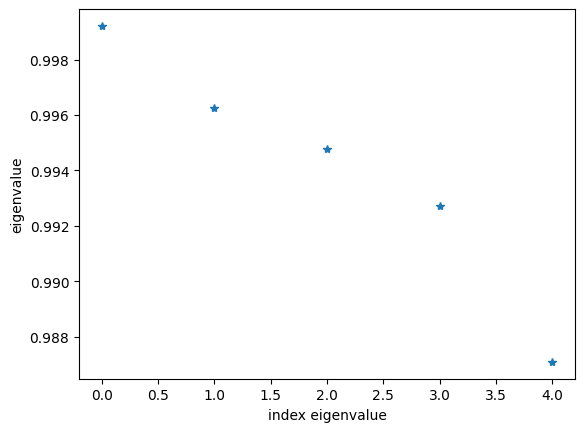

In [16]:
#plot size of the eigenvalues
plot_eigenvalues(sorted_eigenvalues)

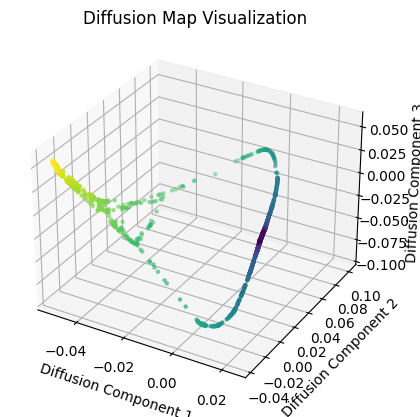

In [17]:
%matplotlib inline
plot_diffusion_map(diffusion_map, dimensions = 3,color = color)

Text(0, 0.5, 'Diffusion Component 2')

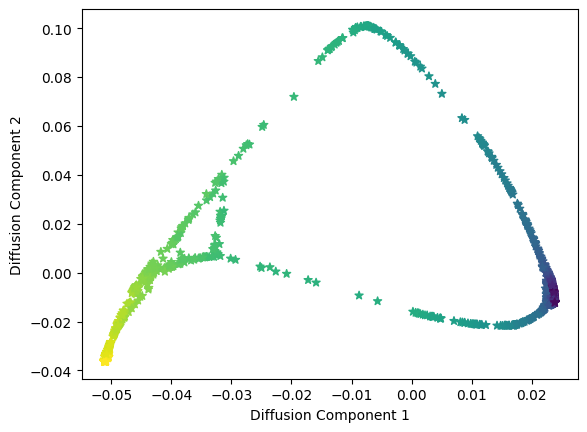

In [18]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(diffusion_map[:, 0], diffusion_map[:, 1],marker = "*",c=color)
ax.set_xlabel('Diffusion Component 1')
ax.set_ylabel('Diffusion Component 2')

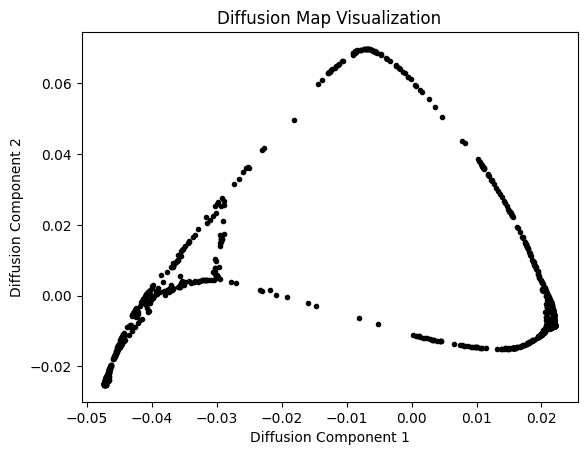

In [19]:
dmap = (sorted_eigenvalues**100)*sorted_eigenvectors
plot_diffusion_map(dmap,dimensions=2)

In [20]:
sorted_eigenvalues**1

array([0.99921405, 0.99626492, 0.99476743, 0.99271785, 0.98708541])